In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow==2.10.0 keras==2.10.0

In [ ]:
!pip install segmentation-models --no-deps

In [ ]:
!pip install efficientnet==1.0.0 image-classifiers==1.0.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.7 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import random

Segmentation Models: using `keras` framework.


In [ ]:
sm.set_framework('tf.keras')

# Data loading and manipulation

In [ ]:
def data_loader(folder_dir):
    image_dataset = []
    image_names = sorted(os.listdir(folder_dir))
    for image_name in image_names:
        image = cv2.imread(os.path.join(folder_dir, image_name), 1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (512, 768))
        image = Image.fromarray(image)
        image = np.array(image)
        image_dataset.append(image)
    return image_dataset, image_names


In [ ]:
image_dataset, image_names = data_loader("/content/drive/MyDrive/Colab Notebooks/dataset/original_img")

In [ ]:
mask_dataset, mask_names = data_loader("/content/drive/MyDrive/Colab Notebooks/dataset/segmentation_img")

In [ ]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [ ]:
mask_dataset.shape

(2000, 768, 512, 3)

In [ ]:
mask_labels = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset/class_dict.csv", sep=';')

In [ ]:
mask_labels

,name,r,g,b
0,backgound,0,0,0
1,table,140,25,255
2,obj,140,255,25


In [ ]:
# converting 3 values RGB to 1 label value
def rgb_to_labels(img, mask_labels):
  label_seg = np.zeros(img.shape, dtype=np.uint8)
  for i in range(mask_labels.shape[0]):
    label_seg[np.all(img == list(mask_labels.iloc[i, [1,2,3]]), axis = -1)] = i
  label_seg = label_seg[:,:,0]
  return label_seg

In [ ]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_labels(mask_dataset[i], mask_labels)
  labels.append(label)

In [ ]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [ ]:
#print("Unique labels in label dataset are: ", np.unique(labels))

In [ ]:
n_classes = len(np.unique(labels))
labels_cut = to_categorical(labels, num_classes = n_classes)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(image_dataset, labels_cut, test_size = 0.20, random_state = 42)

# Modelling

In [ ]:
#using weights from pretrained model
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# preprocess input
x_train_prepr = preprocess_input(x_train)
x_test_prepr = preprocess_input(x_test)

# Using UNet architecture

In [ ]:
#define model
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

85521592/85521592 [==============================] - 1s 0us/step


In [ ]:
metrics=['accuracy']
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [ ]:
model_resnet_backbone.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [ ]:
history = model_resnet_backbone.fit(x_train_prepr,
                                    y_train,
                                    batch_size=16,
                                    epochs=3,
                                    verbose=1,
                                    validation_data=(x_test_prepr, y_test))

Epoch 1/3
100/100 [==============================] - 1231s 12s/step - loss: 0.2087 - accuracy: 0.9402 - val_loss: 0.8120 - val_accuracy: 0.6977
Epoch 2/3
100/100 [==============================] - 1228s 12s/step - loss: 0.0343 - accuracy: 0.9909 - val_loss: 0.1006 - val_accuracy: 0.9755
Epoch 3/3
100/100 [==============================] - 1222s 12s/step - loss: 0.0339 - accuracy: 0.9895 - val_loss: 0.2149 - val_accuracy: 0.9267


# Results

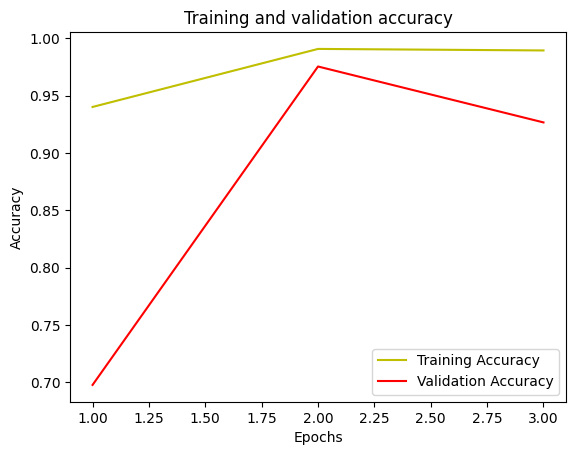

In [ ]:
history = history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model_resnet_backbone.save('/content/drive/MyDrive/Colab Notebooks/unet.hdf5')

#**Predictions**

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/unet.hdf5')

In [ ]:
#making predictions
y_pred = model.predict(x_test)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)


13/13 [==============================] - 77s 6s/step


In [ ]:
output_dir = "/content/drive/MyDrive/Colab Notebooks/predictions"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i in range(len(x_test) - 1):
    test_img = x_test[i]
    ground_truth = y_test_argmax[i]
    test_img_input = np.expand_dims(test_img, 0)
    # Predizione
    prediction = model.predict(test_img_input)
    predicted_img = np.argmax(prediction, axis=3)[0, :, :]
    # Salva l'immagine di predizione
    plt.imsave(os.path.join(output_dir, f'predicted_img_{i}.png'), predicted_img)


1/1 [==============================] - 0s 319ms/step


In [ ]:
#randomly select an image from the test set and making prediction
test_img_number = random.randint(0, len(x_test))
print(test_img_number)
test_img = x_test[test_img_number]
ground_truth = y_test_argmax[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img = np.argmax(prediction, axis=3)[0, :, :]

83
1/1 [==============================] - 0s 402ms/step


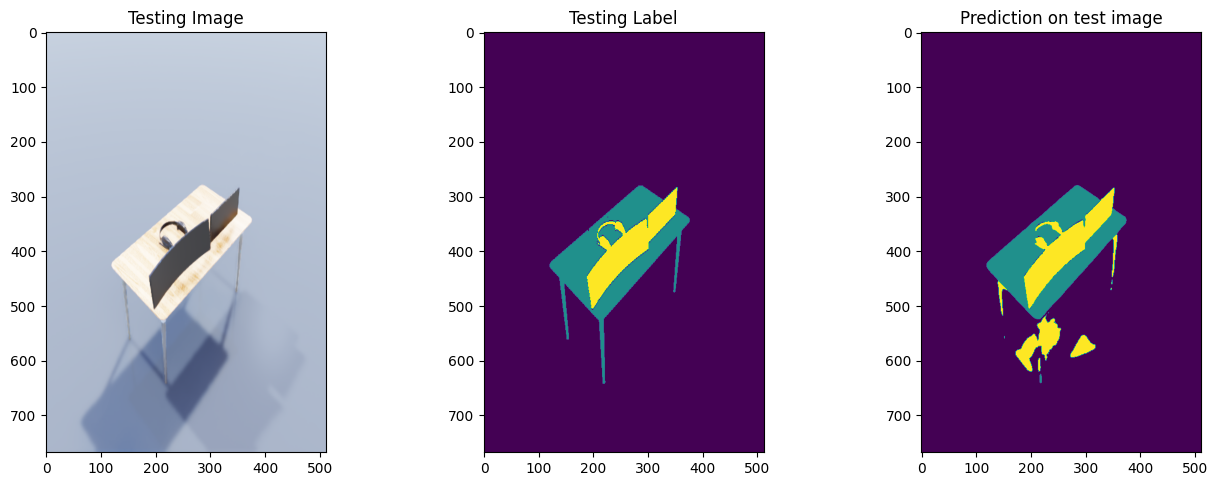

In [ ]:
#plotting the real image, test, labeled image and predicted labeled image
plt.figure(figsize=(16,12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()